## Import packages

In [1]:
# ignore scanpy warnings
import warnings

warnings.filterwarnings("ignore")

import scipy
import networkx as nx
import numpy as np
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv, MLP
from torch_geometric.nn.dense.linear import Linear
from tqdm import tqdm

## Load dataset

In [2]:
adata = sq.datasets.merfish()
adata

AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

## Preprocessing
Our data is stored in Anndata format, which behaves similar to pandas DataFrames. We can access the data matrix using the `.X` attribute. We can also access the cell and gene names using the `.obs_names` and `.var_names` attributes, respectively.

In [3]:
# select one slice
bregma = 1
adata = adata[adata.obs["Bregma"] == bregma, :].copy()

# filtering
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

# normalization
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [4]:
top_gene_idx = adata.X.toarray().sum(axis=0).argmax()
top_gene = adata.var_names[top_gene_idx]
print(f"The gene with the highest total expression is {top_gene}")

The gene with the highest total expression is Cspg5


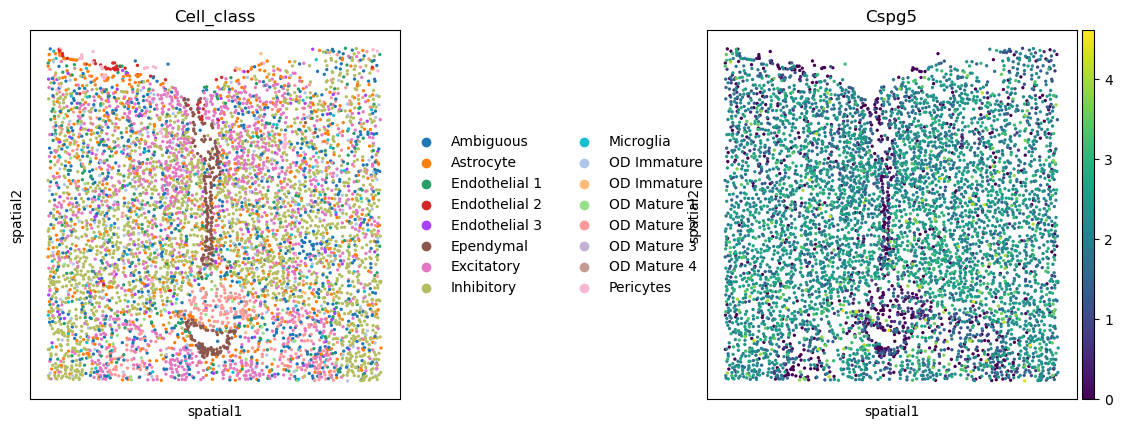

In [5]:
sc.pl.spatial(adata, color=["Cell_class", top_gene], spot_size=0.01)

## Construct graph by connecting each cells to its k nearest neighbors

Here we want to connect each node to its k nearest neighbors, while ensuring the graph is undirected

In [6]:
k = 10

coords = adata.obsm["spatial"]
kdtree = scipy.spatial.KDTree(coords)
distances, indices = kdtree.query(coords, k=k + 1, p=2)

In [7]:
print("Indices:\n", indices)
print(f"Indices shape: {indices.shape}")

Indices:
 [[   0   51 5683 ...   39   12   52]
 [   1    8    4 ... 5679   53   46]
 [   2 5679    5 ...   10    8   15]
 ...
 [6103 5615 5668 ... 5644 5675 5619]
 [6104 5676 5630 ... 5616 5628 5634]
 [6105 5605 6101 ... 5581 5518 5598]]
Indices shape: (6106, 11)


In [8]:
edge_index = torch.cat(
    [
        torch.tensor(indices.flatten())[None, :],  # source
        torch.arange(0, coords.shape[0]).repeat_interleave(k + 1)[None, :],  # target
    ],
    axis=0,
)
edge_weight = torch.tensor(distances.flatten()).unsqueeze(-1).to(torch.float32)

In [9]:
edge_index, edge_weight = pyg.utils.to_undirected(edge_index, edge_weight)

In [10]:
print(f"The graph is undirected: {pyg.utils.is_undirected(edge_index)}")

The graph is undirected: True


Lets visualize the graph using networkx

In [11]:
data = Data(edge_index=edge_index, num_nodes=coords.shape[0])
g = pyg.utils.to_networkx(data, to_undirected=True)

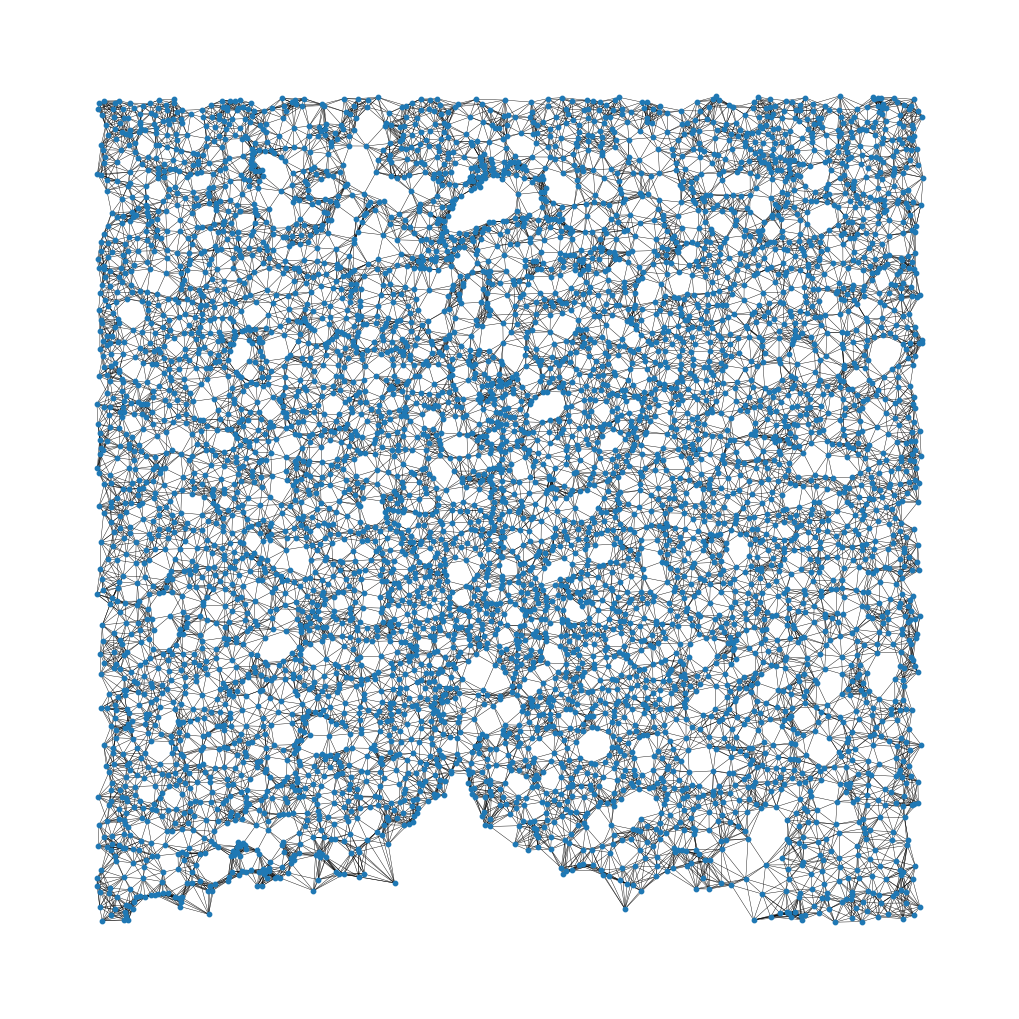

In [12]:
# Remove self-loops for better visualization
g.remove_edges_from(nx.selfloop_edges(g))

plt.figure(figsize=(10, 10))
nx.draw(g, pos=coords, node_size=10, width=0.3)

## Task 1: construct a graph by connecting cells only if they are within a certain distance of each other
Hint: you can loop over all possible pairs of cells using a nested for loop and calculate the distance between them using the `np.linalg.norm` function

In [ ]:
radius = 0.1

# define empty matrices to hold the results
dist_mat = np.zeros((coords.shape[0], coords.shape[0]))
adj_mat = np.zeros((coords.shape[0], coords.shape[0]))

In [13]:
for i in tqdm(range(coords.shape[0])):
    for j in range(i, coords.shape[0]):
        distance = np.linalg.norm(coords[i] - coords[j])
        if distance <= radius:
            dist_mat[i, j] = distance
            dist_mat[j, i] = distance
            adj_mat[i, j] = 1
            adj_mat[j, i] = 1

  3%|▎         | 164/6106 [00:03<02:14, 44.25it/s]

100%|██████████| 6106/6106 [01:09<00:00, 88.18it/s] 


Scipy provides some optimized functions for this task.

In [14]:
kdtree = scipy.spatial.KDTree(coords)
dist_mat_hat = kdtree.sparse_distance_matrix(kdtree, radius, p=2)
dist_mat_hat = scipy.sparse.csr_matrix(dist_mat_hat)
adj_mat_hat = (dist_mat_hat > 0).toarray().astype(int)

In [15]:
print(
    "The results are the same:",
    (adj_mat_hat + np.eye(adj_mat_hat.shape[0]) == adj_mat).all(),
)

print(
    "The results are the same:",
    (dist_mat_hat.toarray() == dist_mat).all(),
)

The results are the same: True
The results are the same: True


Execute the cell below if you want to run the subsequent computation on the distance graph instead of the nearest neighbor graph

In [16]:
# edge_index, edge_weight = pyg.utils.from_scipy_sparse_matrix(dist_mat_hat)

## Task 2: aggregate the gene expression per neighborhood
This is our target per cell neighborhood for the graph autoencoder

In a first version we perform the aggregation with a simple matrix multiplication (for the distance-based case we could have directly used the adj mat.)  
Hint 1: you can convert the edge_index to a sparse matrix using the `pyg.utils.to_scipy_sparse_matrix` function  
Hint 2: the gene expression is stored in the `.X` attribute of the Anndata object

In [17]:
A = pyg.utils.to_scipy_sparse_matrix(edge_index)
A_mean = A / A.sum(axis=1)
X_agg = A_mean @ adata.X

We can perform the same cell aggregation in the Pytorch Geometric Message Passing Framework

In [18]:
class GraphAggregation(MessagePassing):
    """
    GraphAggregation class for aggregating node features in a graph.

    Args:
        aggr (str): Aggregation method to use. Default is "mean".

    """

    def __init__(self, aggr="mean"):
        super(GraphAggregation, self).__init__(aggr=aggr)

    def forward(self, x, edge_index, **kwargs):
        """
        Forward pass of the GraphAggregation module.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Graph edge indices.

        Returns:
            Tensor: Aggregated node features.

        """
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        """
        Message function for the GraphAggregation module.

        Args:
            x_j (Tensor): Node features of neighboring nodes.

        Returns:
            Tensor: The input node features.

        """
        return x_j

In [19]:
mean_agg = GraphAggregation(aggr="mean")
X = torch.Tensor(adata.X.toarray())
X_agg_pyg = mean_agg(X, edge_index)

In [20]:
print(
    "Results are the same (up to numeric error):",
    np.allclose(X_agg.toarray(), X_agg_pyg.numpy(), atol=1e-9),
)

Results are the same (up to numeric error): True


## Task 3: define your own graph convolutional network in Pytorch Geometric

The equation for the graph convolutional layer is given by:
$$
H^{i+1} = (\hat{D}^{-\frac{1}{2}} \hat{A} \hat{D}^{-\frac{1}{2}}) H^{i} W + b
$$
However, you can ignore the normalization for now (already handled by `gcn_norm`) and just implement the last part of the equation:
$$
H^{i+1} = \dots H^{i} W + b
$$

In [21]:
def gcn_norm(edge_index, num_nodes, edge_weight=None, dtype=None):
    """
    Applies graph convolutional network (GCN) normalization to the given edge index and edge weight.

    Args:
        edge_index (Tensor): The edge index tensor of shape (2, num_edges) representing the connectivity of the graph.
        num_nodes (int): The total number of nodes in the graph.
        edge_weight (Tensor, optional): The edge weight tensor of shape (num_edges,) representing the weight of each edge. Defaults to None.
        dtype (torch.dtype, optional): The desired data type of the edge weight tensor. Defaults to None.

    Returns:
        Tuple[Tensor, Tensor]: A tuple containing the updated edge index tensor and the normalized edge weight tensor.

    """
    if edge_weight is None:
        edge_weight = torch.ones(
            (edge_index.size(1),), device=edge_index.device, dtype=dtype
        )

    row, col = edge_index[0], edge_index[1]
    idx = col
    deg = pyg.utils.scatter(edge_weight, idx, dim=0, dim_size=num_nodes, reduce="sum")

    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float("inf"), 0)
    edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    return edge_index, edge_weight

In [22]:
class GCNLayer(MessagePassing):
    """Graph Convolutional Network (GCN) layer implementation.

    This class represents a single layer of a Graph Convolutional Network (GCN).
    It performs message passing and aggregation operations on a graph.

    Args:
        in_channels (int): Number of input channels/features.
        out_channels (int): Number of output channels/features.
        normalize (bool, optional): Whether to normalize the edge weights. Defaults to True.
        aggr (str, optional): Aggregation method for message passing. Defaults to "add".

    Attributes:
        linear (torch.nn.Linear): Linear transformation layer.
        bias (torch.nn.Parameter): Bias parameter.

    """

    def __init__(self, in_channels, out_channels, normalize=True, aggr="add"):
        super(GCNLayer, self).__init__(aggr=aggr)
        self.normalize = normalize

        self.linear = Linear(
            in_channels, out_channels, bias=False, weight_initializer="glorot"
        )
        self.bias = Parameter(torch.zeros(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_weight=None):
        if self.normalize:
            edge_index, edge_weight = gcn_norm(
                edge_index, x.size(0), edge_weight, dtype=x.dtype
            )
        """
        Here you need to implement the missing parts of the forward pass of the GCN layer. you need to use the self.linear and self.bias
        """
        x = self.linear(x)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight)
        out = out + self.bias
        return out

    def message(self, x_i, x_j, edge_weight=None):
        # the message function allows you to access the node features of the source nodes (x_i) and the target nodes (x_j)
        # any other node level attributes that you pass to the propagate function can also be accessed here
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

In [23]:
# Set the seed for reproducibility
torch.manual_seed(42)

gcn_layer_custom = GCNLayer(adata.X.shape[1], 32)
h_custom = gcn_layer_custom(X_agg_pyg, edge_index)
h_custom

tensor([[ 1.2273,  0.8529, -0.3772,  ...,  0.7987, -0.8296, -1.2554],
        [ 0.5481, -0.1671, -0.6197,  ...,  0.6636, -0.9125, -1.2976],
        [ 0.7186, -0.1014, -0.6908,  ...,  0.6993, -0.9704, -1.2647],
        ...,
        [ 1.1555,  0.8322,  0.7190,  ...,  1.0355, -0.8339, -1.1952],
        [ 1.2136,  0.8151,  0.8227,  ...,  1.0383, -0.7682, -1.0847],
        [ 1.2073,  0.6621,  0.2673,  ...,  1.0520, -0.3292, -1.0725]],
       grad_fn=<AddBackward0>)

### Check that it gives the same result as the built-in GCN implementation

In [24]:
# Set the seed for reproducibility
torch.manual_seed(42)

gcn_layer = GCNConv(adata.X.shape[1], 32, add_self_loops=False)
h = gcn_layer(X_agg_pyg, edge_index)
h

tensor([[ 1.2273,  0.8529, -0.3772,  ...,  0.7987, -0.8296, -1.2554],
        [ 0.5481, -0.1671, -0.6197,  ...,  0.6636, -0.9125, -1.2976],
        [ 0.7186, -0.1014, -0.6908,  ...,  0.6993, -0.9704, -1.2647],
        ...,
        [ 1.1555,  0.8322,  0.7190,  ...,  1.0355, -0.8339, -1.1952],
        [ 1.2136,  0.8151,  0.8227,  ...,  1.0383, -0.7682, -1.0847],
        [ 1.2073,  0.6621,  0.2673,  ...,  1.0520, -0.3292, -1.0725]],
       grad_fn=<AddBackward0>)

In [25]:
print("Results are the same:", torch.allclose(h, h_custom, atol=1e-9))

Results are the same: True


## Bonus 1: formulate the same architecture in native Pytorch using matrix multiplications
Hint: for simplicity you can reuse the gcn_norm function and convert the adjacency matrix to a tensor 

## Bonus 2: implement a more general Message Passing Layer
Hint: adapt the Pytorch Geometric Message Passing class according to the general message passing equation

## Define your node-level graph autoencoder
This model takes as input a cell graph with gene expression features and learns a latent representation of the cell neighborhood by reconstructing the neighborhood gene expression

In [26]:
class GraphEncoder(nn.Module):
    """GraphEncoder is a class that represents a graph encoder module.

    Args:
        in_channels (int): The number of input channels.
        hidden_channels (int): The number of hidden channels.
        n_layers (int, optional): The number of graph convolutional layers. Defaults to 2.
        normalize (bool, optional): Whether to apply normalization. Defaults to True.
    """

    def __init__(self, in_channels, hidden_channels, n_layers=2, normalize=True):
        super(GraphEncoder, self).__init__()
        self.linear = Linear(in_channels, hidden_channels)
        self.convs = nn.ModuleList(
            [
                GCNLayer(hidden_channels, hidden_channels, normalize=normalize)
                for _ in range(n_layers)
            ]
        )

    def forward(self, x, edge_index, edge_weight=None):
        x = self.linear(x)
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            x = F.relu(x)
        return x

In [27]:
class Decoder(nn.Module):
    """Decoder module for the GNN model, uses the Pytorch Geometric MLP for convenience.

    Args:
        in_channels (int): Number of input channels.
        hidden_channels (int): Number of hidden channels.
        out_channels (int): Number of output channels.
        n_layers (int, optional): Number of MLP layers. Defaults to 2.
    """

    def __init__(
        self, in_channels, hidden_channels, out_channels, n_layers=2, **kwargs
    ):
        super(Decoder, self).__init__()
        self.mlp = MLP(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            num_layers=n_layers,
            plain_last=False,
            norm=None,
            **kwargs,
        )

    def forward(self, x):
        return self.mlp(x)

In [28]:
class GraphAutoEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        n_layers_encoder=1,
        n_layers_decoder=1,
        **kwargs,
    ):
        """Initializes a GraphAutoEncoder object.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.
            n_layers_encoder (int, optional): Number of layers in the encoder. Defaults to 1.
            n_layers_decoder (int, optional): Number of layers in the decoder. Defaults to 1.
            **kwargs: Additional keyword arguments.

        Returns:
            None
        """
        super(GraphAutoEncoder, self).__init__()
        self.encoder = GraphEncoder(
            in_channels, hidden_channels, n_layers=n_layers_encoder, **kwargs
        )
        self.decoder = Decoder(
            hidden_channels, hidden_channels, out_channels, n_layers=n_layers_decoder
        )

    def forward(self, x, edge_index, edge_weight=None):
        h = self.encoder(x, edge_index, edge_weight)
        x = self.decoder(h)
        return x

## Train your model

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device}")

You are using cpu


In [30]:
seed = 42
n_epochs = 400
n_genes = adata.X.shape[1]
n_layers_encoder = 1
n_layers_decoder = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = GraphAutoEncoder(n_genes, 32, n_genes, n_layers_encoder, n_layers_decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_agg_pyg, edge_index, edge_weight)
    loss = criterion(out, X_agg_pyg)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.4815702736377716
Epoch 10, Loss: 0.13964006304740906
Epoch 20, Loss: 0.09101641923189163
Epoch 30, Loss: 0.07861173152923584
Epoch 40, Loss: 0.07103586196899414
Epoch 50, Loss: 0.06748098134994507
Epoch 60, Loss: 0.061167243868112564
Epoch 70, Loss: 0.056402407586574554
Epoch 80, Loss: 0.05211244896054268
Epoch 90, Loss: 0.047582294791936874
Epoch 100, Loss: 0.045488014817237854
Epoch 110, Loss: 0.045998264104127884
Epoch 120, Loss: 0.043690331280231476
Epoch 130, Loss: 0.04183406010270119
Epoch 140, Loss: 0.04061026871204376
Epoch 150, Loss: 0.03953477740287781
Epoch 160, Loss: 0.03869973495602608
Epoch 170, Loss: 0.038595639169216156
Epoch 180, Loss: 0.037554994225502014
Epoch 190, Loss: 0.03673526272177696
Epoch 200, Loss: 0.03601223975419998
Epoch 210, Loss: 0.03548606112599373
Epoch 220, Loss: 0.03505612164735794
Epoch 230, Loss: 0.035047564655542374
Epoch 240, Loss: 0.034520212560892105
Epoch 250, Loss: 0.03402242809534073
Epoch 260, Loss: 0.03385874629020691
Epo

## Task 4: Extract and visualize the latent embeddings
Hint: our model has an encoder that maps the input gene expression to the latent space. We can use this encoder to extract the latent embeddings of the cells

In [ ]:
model.eval()

In [31]:
h = model.encoder(X_agg_pyg, edge_index, edge_weight)
h = h.detach().numpy()

Encoded features shape: (6106, 32)


In [ ]:
print(f"Encoded features shape: {h.shape}")

In [32]:
adata.obsm["X_gnn"] = h

Hint to visualize the embeddings you can use PCA or UMAP

## Define spatial domains via Leiden clustering

In [33]:
sc.pp.neighbors(adata, use_rep="X_gnn")
sc.tl.leiden(adata, resolution=0.1)

## Visualize the spatial domains

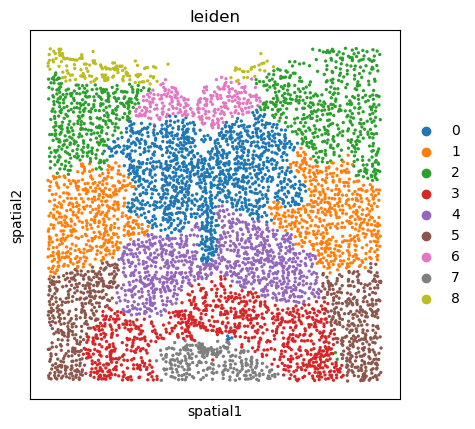

In [34]:
sc.pl.spatial(adata, color="leiden", spot_size=0.01)

## Task 5: Analyze the cell type proportions for each spatial domain
Hint: the only data you need is given in the below DataFrame

In [36]:
df = adata.obs[["leiden", "Cell_class"]]

## Further reading
1. [Geometric deep learning resources](https://geometricdeeplearning.com/)
2. [Graph (variational) autoencoder paper](https://arxiv.org/abs/1611.07308)
3. [Pytorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/)
4. [Google tuning playbook](https://github.com/google-research/tuning_playbook)